# Sentiment Analysis of Helpful and Unhelpful Community Notes

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### First we have to do ann inner join of the notes and ratings datasets by note ID, retrieving the summary (community note content), helpfulness level (helpful or unhelpful), and the attribute columns that label why the community note was helpful for unhelpful. 

### Below I've extracted the helpful dataset, which contains the columns "helpfulClear," "helpfulUnbiasedLanguage," "helpfulImportantContext," and "helpfulGoodSources."

### I'm looking into how helpfulness is determined via sentiment analysis in the following attribute categories:
 - Clarity (clear)
 - Unbiased language
 - Important Context
 - Good Sources

In [2]:
notes_df = pd.read_csv('data/notes.csv')
ratings_df = pd.read_csv('data/ratings.csv')
merged_df = pd.merge(notes_df, ratings_df, on='noteId', how='inner')
helpful_df = merged_df[['noteId', 'summary', 'helpfulnessLevel', 'noteAuthorParticipantId', 'helpfulClear', 'helpfulUnbiasedLanguage','helpfulImportantContext', 'helpfulGoodSources']]
# Remove duplicate rows
helpful = helpful_df.drop_duplicates(subset=['noteId', 'summary', 'noteAuthorParticipantId'])
helpful

,noteId,summary,helpfulnessLevel,noteAuthorParticipantId,helpfulClear,helpfulUnbiasedLanguage,helpfulImportantContext,helpfulGoodSources
0,1783181538789605871,The United States has 50 States https://da...,HELPFUL,C784F04F26E124F4D6EC01658D8F5565005D3092741FB3...,1,1,1,1
4,1586769867381669889,"Clinton is not alone in this claim, the F.B.I....",HELPFUL,5684B38EB58FD8BE75ABA37F0BE040EC70380B002ADF9D...,1,1,1,1
5,1575594018691420160,This may be the first public demonstration of ...,HELPFUL,DEB44EE644DD2F0AB97021D46CD7ABE322BF0199CDC38B...,0,0,0,0
6,1591119055103983616,Yoel Roth is no longer the head of Twitter’s ...,HELPFUL,DEB44EE644DD2F0AB97021D46CD7ABE322BF0199CDC38B...,1,1,1,1
7,1763035751002808656,"While a Republican Senator, Cindy Hyde-Smith i...",NOT_HELPFUL,4BB4813625461AE3B657AA76389AD6F9C6A9EE05B0C183...,0,0,0,0
...,...,...,...,...,...,...,...,...
13533,1769857672114024502,shope.ee/2AqghSiwVQ Akun2 yang merusak ikl...,HELPFUL,F2C463A0653C0B8BEC74317C3EB028AE6AA3A83495F5BE...,0,0,0,0
13534,1775711591646081459,&quot;auschwitz.history&quot; is not the actua...,NOT_HELPFUL,4CB461F5149875E1A34CB5FC0C435B4E0BC9BB5CAF9348...,0,0,0,0
13535,1746787265626476833,Der AfD-Antrag wurde abgelehnt. Das beschlosse...,HELPFUL,90AB3A4A4AE4D20223527F29BFA8844EE444918B19C671...,1,1,1,1
13536,1746799072147653096,Es handelt sich im Fall der Gastronomie nicht ...,HELPFUL,90AB3A4A4AE4D20223527F29BFA8844EE444918B19C671...,1,1,1,1


### Perform text cleaning and preprocessing for sentiment anaysis
- Remove stop words, special characters, and normalization
- Lemmatization and word tokenization
- remove languages besides English

In [5]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from langdetect import detect

In [4]:
def clean_text(text):
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert text to lowercase
    text = text.lower()
    return text

helpful['cleaned_text'] = helpful['summary'].apply(clean_text)

# Print the cleaned text
print("Cleaned text")
print(helpful['cleaned_text'])

Cleaned text
0        the united states has  states     httpsdatacen...
4        clinton is not alone in this claim the fbi has...
5        this may be the first public demonstration of ...
6        yoel roth is no longer the head of  twitters t...
7        while a republican senator cindy hydesmith ind...
                               ...                        
13533     shopeeeaqghsiwvq    akun yang merusak iklim p...
13534    quotauschwitzhistoryquot is not the actual acc...
13535    der afdantrag wurde abgelehnt das beschlossene...
13536    es handelt sich im fall der gastronomie nicht ...
13537    nn das ist kein fall fr die cns sondern fr die...
Name: cleaned_text, Length: 9737, dtype: object


<ipython-input-4-62695f60caf7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  helpful['cleaned_text'] = helpful['summary'].apply(clean_text)


In [6]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # Lemmatize the tokens
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    # Join the tokens back into a single string
    processed_text = ' '.join(lemmatized_tokens)
    return processed_text

def detect_language(text):
    try:
        lang = detect(text)
        return lang == 'en'
    except:
        return False

helpful['preprocessed_text'] = helpful['cleaned_text'].apply(preprocess_text)

helpful = helpful[helpful['preprocessed_text'].apply(detect_language)]

# print("Preprocessed Text:")
# print(helpful['preprocessed_text'])
helpful

<ipython-input-6-7bf66a25e317>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  helpful['preprocessed_text'] = helpful['cleaned_text'].apply(preprocess_text)


,noteId,summary,helpfulnessLevel,noteAuthorParticipantId,helpfulClear,helpfulUnbiasedLanguage,helpfulImportantContext,helpfulGoodSources,cleaned_text,preprocessed_text
0,1783181538789605871,The United States has 50 States https://da...,HELPFUL,C784F04F26E124F4D6EC01658D8F5565005D3092741FB3...,1,1,1,1,the united states has states httpsdatacen...,united state state httpsdatacensusgovallprofil...
4,1586769867381669889,"Clinton is not alone in this claim, the F.B.I....",HELPFUL,5684B38EB58FD8BE75ABA37F0BE040EC70380B002ADF9D...,1,1,1,1,clinton is not alone in this claim the fbi has...,clinton alone claim fbi repeatedly said extrem...
5,1575594018691420160,This may be the first public demonstration of ...,HELPFUL,DEB44EE644DD2F0AB97021D46CD7ABE322BF0199CDC38B...,0,0,0,0,this may be the first public demonstration of ...,may first public demonstration postpublishing ...
6,1591119055103983616,Yoel Roth is no longer the head of Twitter’s ...,HELPFUL,DEB44EE644DD2F0AB97021D46CD7ABE322BF0199CDC38B...,1,1,1,1,yoel roth is no longer the head of twitters t...,yoel roth longer head twitter trust amp safety...
7,1763035751002808656,"While a Republican Senator, Cindy Hyde-Smith i...",NOT_HELPFUL,4BB4813625461AE3B657AA76389AD6F9C6A9EE05B0C183...,0,0,0,0,while a republican senator cindy hydesmith ind...,republican senator cindy hydesmith indeed bloc...
...,...,...,...,...,...,...,...,...,...,...
13529,1685006217792389120,No it hasn't. Rees-Mogg is one of our most stu...,NOT_HELPFUL,D2FA56A4FF6C8FE55607BC4987A5FEA0131EEDC00E2BA6...,0,0,0,0,no it hasnt reesmogg is one of our most stupid...,hasnt reesmogg one stupid mp httpswwwtheneweur...
13530,1744811920148906128,"Starmer, like a lot of lawyers worked pro bono...",HELPFUL,D2FA56A4FF6C8FE55607BC4987A5FEA0131EEDC00E2BA6...,0,0,1,0,starmer like a lot of lawyers worked pro bono ...,starmer like lot lawyer worked pro bono reduce...
13531,1381801525840904192,Murder is decided by a jury; it is not decided...,NaN,F35972BBD2F99515FD974E9C7AFD899970F2E4A5911513...,0,0,0,1,murder is decided by a jury it is not decided ...,murder decided jury decided medical examiner h...
13532,1767348671341822423,Equity Florida falsely states that the settlem...,NOT_HELPFUL,F35972BBD2F99515FD974E9C7AFD899970F2E4A5911513...,0,0,0,0,equity florida falsely states that the settlem...,equity florida falsely state settlement change...


### Split the helpful dataset into the four different attribute category datasets:
- Clear
- Unbiased Language
- Important Context
- Good Sources

In [13]:
df_clear_helpful = helpful[helpful['helpfulClear'] == 1]
df_unbiased_helpful = helpful[helpful['helpfulUnbiasedLanguage'] == 1]
df_context_helpful = helpful[helpful['helpfulImportantContext'] == 1]
df_sources_helpful = helpful[helpful['helpfulGoodSources'] == 1]

clear_helpful = df_clear_helpful['preprocessed_text']
unbiased_helpful = df_unbiased_helpful['preprocessed_text']
context_helpful = df_context_helpful['preprocessed_text']
sources_helpful = df_sources_helpful['preprocessed_text']

### Create the Unhelpful data set and split it into the different unhelpful category datasets:
- Argumentative or Biased
- Opinion or Speculation
- Spam, Harassment, or Abuse
- Hard to Understand

In [22]:
not_helpful_df = merged_df[['noteId', 'summary', 'helpfulnessLevel', 'noteAuthorParticipantId', 'notHelpfulArgumentativeOrBiased','notHelpfulOpinionSpeculation', 'notHelpfulSpamHarassmentOrAbuse', 'notHelpfulHardToUnderstand']]
# Remove duplicate rows
unhelpful = not_helpful_df.drop_duplicates(subset=['noteId', 'summary', 'noteAuthorParticipantId'])

unhelpful['cleaned_text'] = unhelpful['summary'].apply(clean_text)

unhelpful['preprocessed_text'] = unhelpful['cleaned_text'].apply(preprocess_text)

unhelpful = unhelpful[unhelpful['preprocessed_text'].apply(detect_language)]

# Display the deduplicated DataFrame
unhelpful

<ipython-input-22-941bd616e242>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unhelpful['cleaned_text'] = unhelpful['summary'].apply(clean_text)
<ipython-input-22-941bd616e242>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unhelpful['preprocessed_text'] = unhelpful['cleaned_text'].apply(preprocess_text)


,noteId,summary,helpfulnessLevel,noteAuthorParticipantId,notHelpfulArgumentativeOrBiased,notHelpfulOpinionSpeculation,notHelpfulSpamHarassmentOrAbuse,notHelpfulHardToUnderstand,cleaned_text,preprocessed_text
0,1783181538789605871,The United States has 50 States https://da...,HELPFUL,C784F04F26E124F4D6EC01658D8F5565005D3092741FB3...,0,0,0,0,the united states has states httpsdatacen...,united state state httpsdatacensusgovallprofil...
4,1586769867381669889,"Clinton is not alone in this claim, the F.B.I....",HELPFUL,5684B38EB58FD8BE75ABA37F0BE040EC70380B002ADF9D...,0,0,0,0,clinton is not alone in this claim the fbi has...,clinton alone claim fbi repeatedly said extrem...
5,1575594018691420160,This may be the first public demonstration of ...,HELPFUL,DEB44EE644DD2F0AB97021D46CD7ABE322BF0199CDC38B...,0,0,0,0,this may be the first public demonstration of ...,may first public demonstration postpublishing ...
6,1591119055103983616,Yoel Roth is no longer the head of Twitter’s ...,HELPFUL,DEB44EE644DD2F0AB97021D46CD7ABE322BF0199CDC38B...,0,0,0,0,yoel roth is no longer the head of twitters t...,yoel roth longer head twitter trust amp safety...
7,1763035751002808656,"While a Republican Senator, Cindy Hyde-Smith i...",NOT_HELPFUL,4BB4813625461AE3B657AA76389AD6F9C6A9EE05B0C183...,1,0,0,0,while a republican senator cindy hydesmith ind...,republican senator cindy hydesmith indeed bloc...
...,...,...,...,...,...,...,...,...,...,...
13529,1685006217792389120,No it hasn't. Rees-Mogg is one of our most stu...,NOT_HELPFUL,D2FA56A4FF6C8FE55607BC4987A5FEA0131EEDC00E2BA6...,1,0,0,0,no it hasnt reesmogg is one of our most stupid...,hasnt reesmogg one stupid mp httpswwwtheneweur...
13530,1744811920148906128,"Starmer, like a lot of lawyers worked pro bono...",HELPFUL,D2FA56A4FF6C8FE55607BC4987A5FEA0131EEDC00E2BA6...,0,0,0,0,starmer like a lot of lawyers worked pro bono ...,starmer like lot lawyer worked pro bono reduce...
13531,1381801525840904192,Murder is decided by a jury; it is not decided...,NaN,F35972BBD2F99515FD974E9C7AFD899970F2E4A5911513...,0,0,0,0,murder is decided by a jury it is not decided ...,murder decided jury decided medical examiner h...
13532,1767348671341822423,Equity Florida falsely states that the settlem...,NOT_HELPFUL,F35972BBD2F99515FD974E9C7AFD899970F2E4A5911513...,0,0,0,0,equity florida falsely states that the settlem...,equity florida falsely state settlement change...


In [23]:
df_biased_unhelpful = unhelpful[unhelpful['notHelpfulArgumentativeOrBiased'] == 1]
df_opinion_unhelpful = unhelpful[unhelpful['notHelpfulOpinionSpeculation'] == 1]
df_spam_unhelpful = unhelpful[unhelpful['notHelpfulSpamHarassmentOrAbuse'] == 1]
df_hard_unhelpful = unhelpful[unhelpful['notHelpfulHardToUnderstand'] == 1]

biased_unhelpful = df_biased_unhelpful['preprocessed_text']
opinion_unhelpful = df_opinion_unhelpful['preprocessed_text']
spam_unhelpful = df_spam_unhelpful['preprocessed_text']
hard_unhelpful = df_hard_unhelpful['preprocessed_text']

### Using the SentimentIntensityAnalyzer class from the vader module!
Returns a polarity score of positive, negative, or neutral. 

What is VADER (Valence Aware Dictionary and Sentiment Reasoner)? It is sensitive to both the polarity (positive/negative) and the intensity (strength) of emotions.

In [28]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd

# Download VADER lexicon (only need to do this once)
#nltk.download('vader_lexicon')

# Initialize the VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Function to get sentiment of a text
def get_sentiment(text):
    scores = sid.polarity_scores(text)
    if scores['compound'] >= 0.05:
        return 'positive'
    elif scores['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

In [29]:
df_clear_helpful['sentiment'] = df_clear_helpful['preprocessed_text'].apply(get_sentiment)
df_context_helpful['sentiment'] = df_context_helpful['preprocessed_text'].apply(get_sentiment)
df_unbiased_helpful['sentiment'] = df_unbiased_helpful['preprocessed_text'].apply(get_sentiment)
df_sources_helpful['sentiment'] = df_sources_helpful['preprocessed_text'].apply(get_sentiment)

<ipython-input-29-e4a54a312aee>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clear_helpful['sentiment'] = df_clear_helpful['preprocessed_text'].apply(get_sentiment)
<ipython-input-29-e4a54a312aee>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_context_helpful['sentiment'] = df_context_helpful['preprocessed_text'].apply(get_sentiment)
<ipython-input-29-e4a54a312aee>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

### Overall Sentiment Analysis for Helpful Notes Labeled Clear

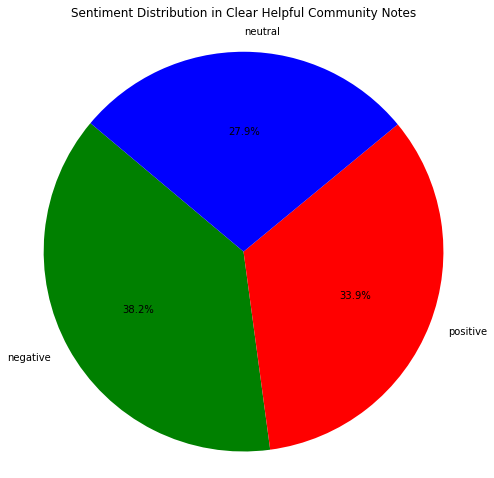

In [49]:
# Count the number of each sentiment category
sentiment_counts = df_clear_helpful['sentiment'].value_counts()

# Create labels for the pie chart
labels = sentiment_counts.index.tolist()

# Create sizes for the pie chart
sizes = sentiment_counts.values.tolist()

# Create colors for the pie chart
colors = ['green', 'red', 'blue']

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution in Clear Helpful Community Notes', y=1.03)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the pie chart
plt.show()

### Overall Sentiment Analysis for Helpful Notes with Good Context

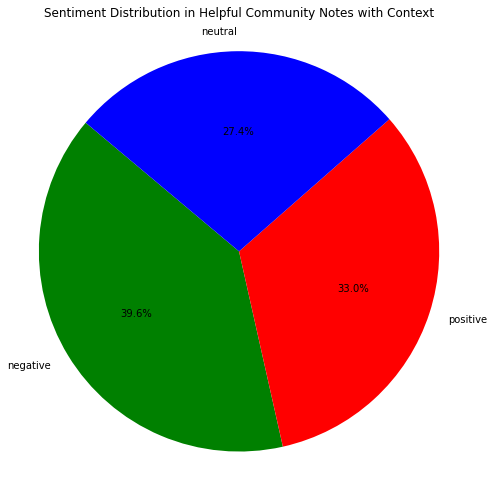

In [48]:
# Count the number of each sentiment category
sentiment_counts = df_context_helpful['sentiment'].value_counts()

# Create labels for the pie chart
labels = sentiment_counts.index.tolist()

# Create sizes for the pie chart
sizes = sentiment_counts.values.tolist()

# Create colors for the pie chart
colors = ['green', 'red', 'blue']

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution in Helpful Community Notes with Context', y=1.03)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the pie chart
plt.show()

### Overall Sentiment Analysis for Helpful Notes with Unbiased Language

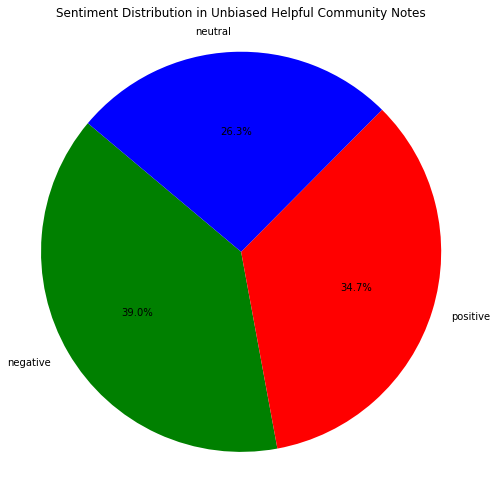

In [47]:
# Count the number of each sentiment category
sentiment_counts = df_unbiased_helpful['sentiment'].value_counts()

# Create labels for the pie chart
labels = sentiment_counts.index.tolist()

# Create sizes for the pie chart
sizes = sentiment_counts.values.tolist()

# Create colors for the pie chart
colors = ['green', 'red', 'blue']

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution in Unbiased Helpful Community Notes', y=1.03)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the pie chart
plt.show()

### Overall Sentiment Analysis for Helpful Notes with Good Sources

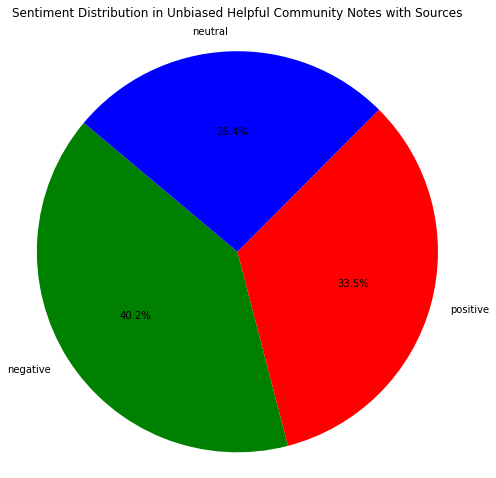

In [46]:
# Count the number of each sentiment category
sentiment_counts = df_sources_helpful['sentiment'].value_counts()

# Create labels for the pie chart
labels = sentiment_counts.index.tolist()

# Create sizes for the pie chart
sizes = sentiment_counts.values.tolist()

# Create colors for the pie chart
colors = ['green', 'red', 'blue']

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution in Unbiased Helpful Community Notes with Sources', y=1.03)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the pie chart
plt.show()

In [36]:
df_biased_unhelpful['sentiment'] = df_biased_unhelpful['preprocessed_text'].apply(get_sentiment)
df_opinion_unhelpful['sentiment'] = df_opinion_unhelpful['preprocessed_text'].apply(get_sentiment)
df_spam_unhelpful['sentiment'] = df_spam_unhelpful['preprocessed_text'].apply(get_sentiment)
df_hard_unhelpful['sentiment'] = df_hard_unhelpful['preprocessed_text'].apply(get_sentiment)

<ipython-input-36-4d7d27ce5771>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_biased_unhelpful['sentiment'] = df_biased_unhelpful['preprocessed_text'].apply(get_sentiment)
<ipython-input-36-4d7d27ce5771>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_opinion_unhelpful['sentiment'] = df_opinion_unhelpful['preprocessed_text'].apply(get_sentiment)
<ipython-input-36-4d7d27ce5771>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

### Overall Sentiment Analysis for Unhelpful Notes with Argumentative or Biased Language

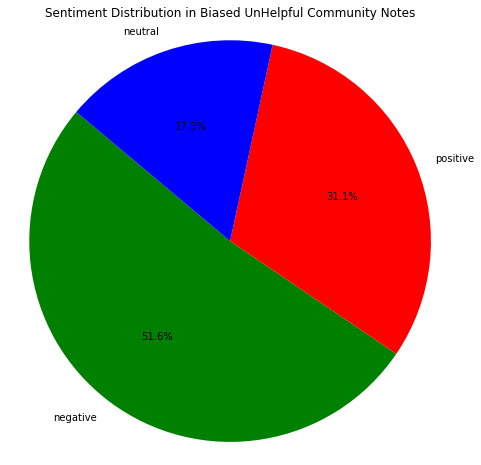

In [37]:
# Count the number of each sentiment category
sentiment_counts = df_biased_unhelpful['sentiment'].value_counts()

# Create labels for the pie chart
labels = sentiment_counts.index.tolist()

# Create sizes for the pie chart
sizes = sentiment_counts.values.tolist()

# Create colors for the pie chart
colors = ['green', 'red', 'blue']

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution in Biased UnHelpful Community Notes')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the pie chart
plt.show()

In [ ]:
df_biased_unhelpful = unhelpful[unhelpful['notHelpfulArgumentativeOrBiased'] == 1]
df_opinion_unhelpful = unhelpful[unhelpful['notHelpfulOpinionSpeculation'] == 1]
df_spam_unhelpful = unhelpful[unhelpful['notHelpfulSpamHarassmentOrAbuse'] == 1]
df_hard_unhelpful = unhelpful[unhelpful['notHelpfulHardToUnderstand'] == 1]

### Overall Sentiment Analysis for Unhelpful Notes Labeled Opinion or Speculation

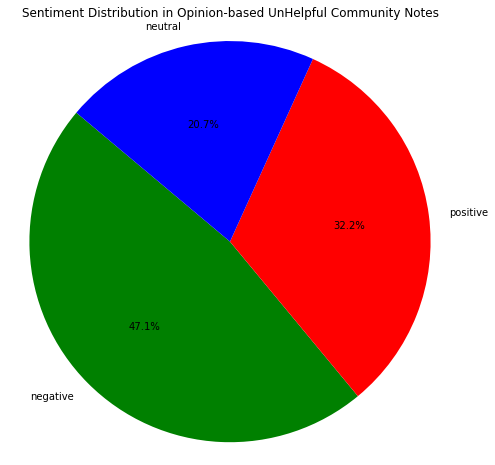

In [38]:
# Count the number of each sentiment category
sentiment_counts = df_opinion_unhelpful['sentiment'].value_counts()

# Create labels for the pie chart
labels = sentiment_counts.index.tolist()

# Create sizes for the pie chart
sizes = sentiment_counts.values.tolist()

# Create colors for the pie chart
colors = ['green', 'red', 'blue']

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution in Opinion-based UnHelpful Community Notes')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the pie chart
plt.show()

### Overall Sentiment Analysis for Unhelpful Notes Labeled Spam

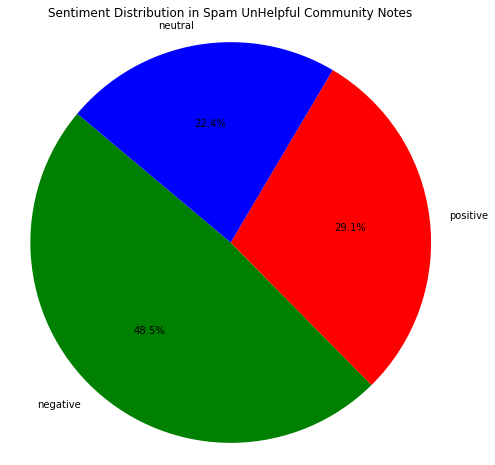

In [39]:
# Count the number of each sentiment category
sentiment_counts = df_spam_unhelpful['sentiment'].value_counts()

# Create labels for the pie chart
labels = sentiment_counts.index.tolist()

# Create sizes for the pie chart
sizes = sentiment_counts.values.tolist()

# Create colors for the pie chart
colors = ['green', 'red', 'blue']

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution in Spam UnHelpful Community Notes')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the pie chart
plt.show()

### Overall Sentiment Analysis for Unhelpful Notes Labeled Hard to Understand

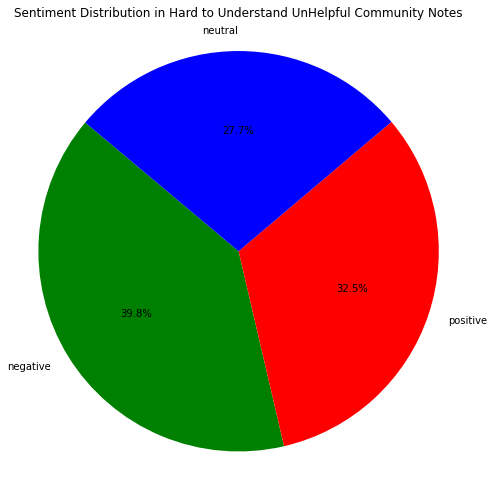

In [44]:
# Count the number of each sentiment category
sentiment_counts = df_hard_unhelpful['sentiment'].value_counts()

# Create labels for the pie chart
labels = sentiment_counts.index.tolist()

# Create sizes for the pie chart
sizes = sentiment_counts.values.tolist()

# Create colors for the pie chart
colors = ['green', 'red', 'blue']

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution in Hard to Understand UnHelpful Community Notes', y=1.03)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the pie chart
plt.show()

### Roadblocks: 
Need to understand the words and characteristics that contribute to the negative sentiment of unhelpful community notes.
### Potential Solution
Identify what the most polar or negative words/phrases that contributors should avoid using in their community notes given the sentiment results for each attribute category.
### Next Steps
Evaluate readability with Flesch Reading Ease" and Gunning Fog Index (estimates the years of formal education needed) Also look into name entity recognition. 